## Notebook Content

In this notebook, we will try to optimize our data (Feature-Engineering) in order to genereate the best model score.

## Import Libraries

In [88]:
import sqlite3 as sql
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import partial_dependence
from mpl_toolkits.mplot3d.axes3d import Axes3D

### Read Data from SQL

In [89]:
Xs_val_train_connection = sql.connect('Xs_val_train.db')
Xs_val_train = pd.read_sql('SELECT * FROM Xs_val_train', Xs_val_train_connection)

In [90]:
Xs_test_connection= sql.connect('Xs_test.db')
Xs_test = pd.read_sql('SELECT * FROM Xs_test', Xs_test_connection)

In [91]:
y_val_train_connection= sql.connect('y_val_train.db')
y_val_train = pd.read_sql('SELECT * FROM y_val_train', y_val_train_connection)

In [92]:
All_df_connection= sql.connect('Cleaned_df.db')
All_df = pd.read_sql('SELECT * FROM Cleaned_df', All_df_connection)
All_df.drop(['TRANS_FAT','CHOLESTEROL','VITAMIN_D','index'], axis = 1, inplace = True)

### Drop Index Column

In [93]:
Xs_val_train.drop('index', axis='columns', inplace = True)
Xs_test.drop('index', axis='columns', inplace = True)
y_val_train.drop('index', axis='columns', inplace = True)

### Data Correlation

In [94]:
corr = All_df.corr()

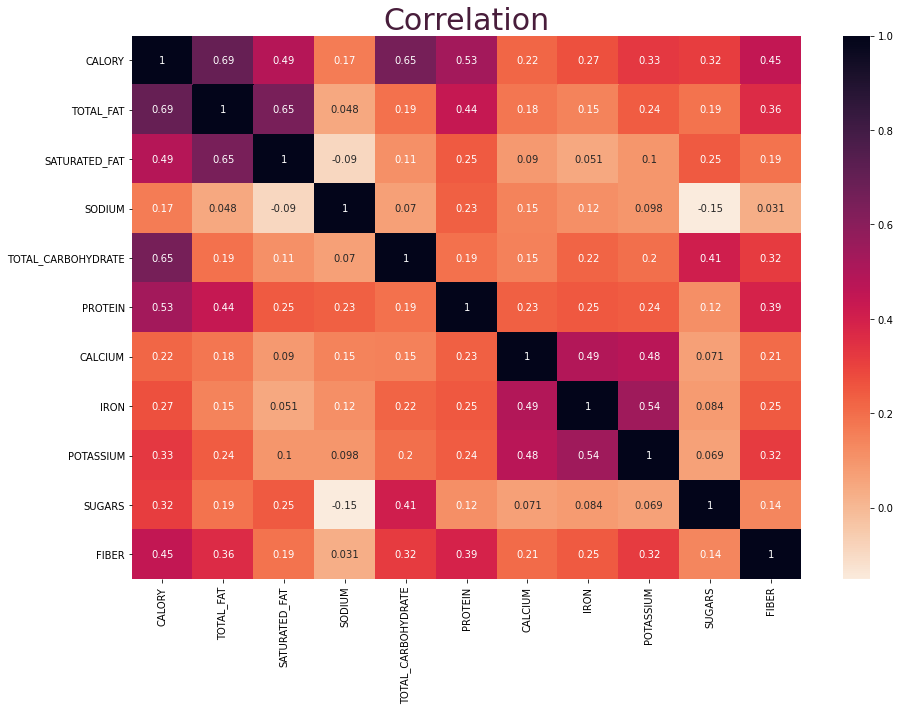

In [109]:
plt.figure(figsize = [15,10])
sns.heatmap(corr, annot = True, cmap = sns.cm.rocket_r );
plt.title('Correlation', color= '#481D3B', fontsize=30);

### Split Data

In [96]:
Xs_train , Xs_val, y_train, y_val = train_test_split(Xs_val_train, y_val_train, test_size=.25, random_state = 10) 

### Gradient Boosting Model

In [100]:
# define a list of all columns names to uae them in plotting.
columns_names= ["Total Fat","Saturated Fat", "Trans Fat", "Cholesterol", "Sodium", "Total Carbohydrate",
               "Protein", "Vitamin D", "Calcium", "Iron", "Potassium", "Sugars", "Fiber"]

In [101]:
model = GradientBoostingRegressor()
fitting = model.fit(Xs_train,y_train.values.ravel())

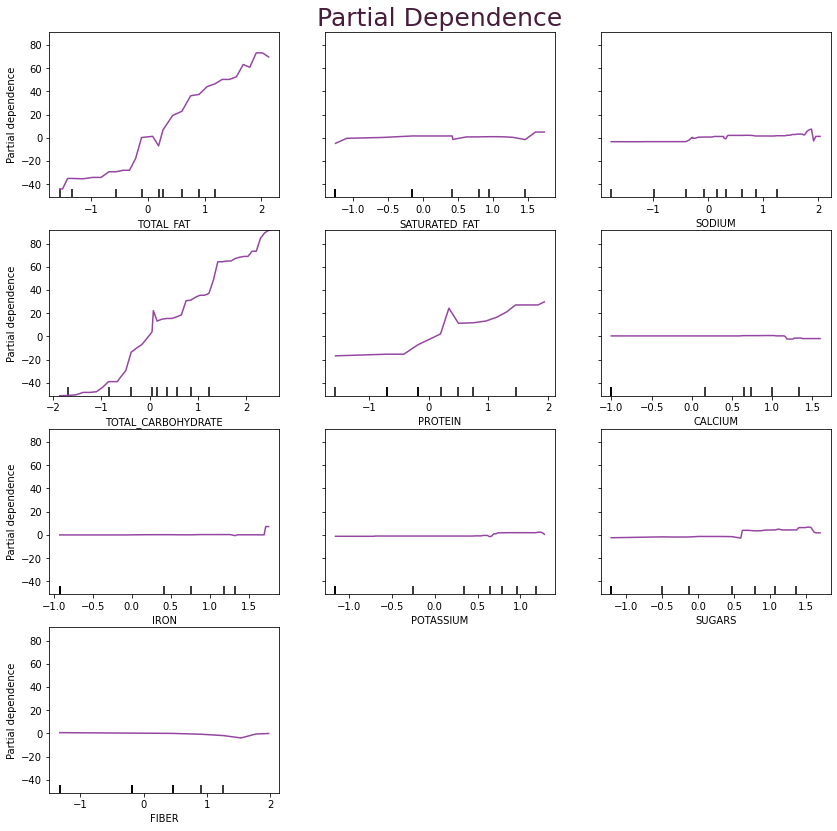

In [107]:
# draw the patial dependence of each feature
fig, ax = plt.subplots(figsize=(14, 14))
plt.title("Partial Dependence", fontsize=25, color= '#481D3B')
fig = plot_partial_dependence(model, Xs_train, Xs_train.columns.values,feature_names = Xs_train.columns.values, 
                              ax=ax, line_kw={"color": "#9546A2"});
plt.savefig('partial_dep.png')

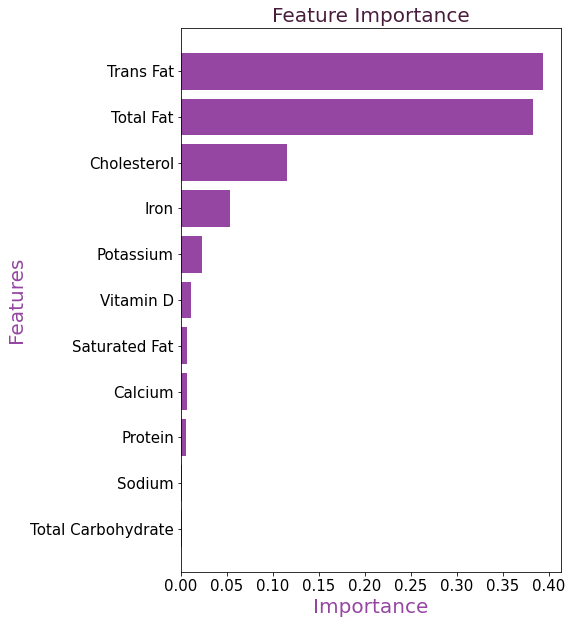

In [80]:
# plot the feature importance for all the features 
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center', color = "#9546A2" )
plt.yticks(pos, np.array(columns_names)[sorted_idx], fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Importance', fontsize=20,  color = "#9546A2")
plt.ylabel('Features', fontsize=20,  color = "#9546A2")
plt.title('Feature Importance',fontsize=20, color= '#481D3B') 
plt.savefig('feautre_imp.png')

In [45]:
def get_new_r2(Xs_train_lc, y_train_lc, Xs_val_lc, y_val_lc):
    """
    This method will be called to fit the training set with score and predict the score for test set.
    After that, it will print all the scores with the difference between them.
    """
    model = GradientBoostingRegressor(random_state = 100)
    fitting = model.fit(Xs_train_lc,y_train_lc.values.ravel())
    t_score= fitting.score(Xs_train_lc,y_train_lc.values.ravel()) * 100
    print('Training score with Gradient Boosting Regressor {:.2f}%'.format(t_score))
    y_preds = fitting.predict(Xs_val_lc)
    v_score= r2_score(y_val_lc.values.ravel(), y_preds)* 100
    print('Validation score with Gradient Boosting Regressor {:.2f}%'.format(v_score))
    print('The difference between scores is {:.2f}%'.format(abs(t_score-v_score)))

In [46]:
def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))

### The Model Before any Features Engineering 

In [47]:
# calling the method to print the scores
get_new_r2(Xs_train, y_train, Xs_val, y_val)

Training score with Gradient Boosting Regressor 94.58%
Validation score with Gradient Boosting Regressor 89.89%
The difference between scores is 4.69%


## Start Features Engineering

### Itration 1

As we can see in the above heatmap there is a collinearity between __TOTAL_FAT__ and __SATURATED_FAT__ we will try to delete __SATURATED_FAT__ since it has less correlation with target and create new column that hold __SATURATED_FAT__ * __TOTAL_FAT__

In [48]:
# We will make a copy from the org datasets beacuse we will not approve all of the changes.
Xs_train_i1 = Xs_train.copy()
Xs_val_i1 = Xs_val.copy()

Xs_train_i1['SATURATED_FAT*TOTAL_FAT'] = Xs_train_i1['SATURATED_FAT'] * Xs_train_i1['TOTAL_FAT']
Xs_train_i1.drop('SATURATED_FAT', axis = 1, inplace = True)

Xs_val_i1['SATURATED_FAT*TOTAL_FAT'] = Xs_val_i1['SATURATED_FAT'] * Xs_val_i1['TOTAL_FAT']
Xs_val_i1.drop('SATURATED_FAT', axis = 1, inplace = True)

get_new_r2(Xs_train_i1, y_train, Xs_val_i1, y_val)

Training score with Gradient Boosting Regressor 94.21%
Validation score with Gradient Boosting Regressor 89.20%
The difference between scores is 5.01%


our scores is decreased so we will try another idea

### Itration 2

we will try to drop __TOTAL_FAT__ column plus to what we do in Itration 1

In [49]:
Xs_train_i2 = Xs_train.copy()
Xs_val_i2 = Xs_val.copy()

Xs_train_i2['SATURATED_FAT*TOTAL_FAT'] = Xs_train_i2['SATURATED_FAT'] * Xs_train_i2['TOTAL_FAT']
Xs_val_i2['SATURATED_FAT*TOTAL_FAT'] = Xs_val_i2['SATURATED_FAT'] * Xs_val_i2['TOTAL_FAT']


Xs_train_i2.drop(['SATURATED_FAT','TOTAL_FAT'], axis = 1, inplace = True)
Xs_val_i2.drop(['SATURATED_FAT','TOTAL_FAT'], axis = 1, inplace = True)

get_new_r2(Xs_train_i2, y_train, Xs_val_i2, y_val)

Training score with Gradient Boosting Regressor 88.81%
Validation score with Gradient Boosting Regressor 78.08%
The difference between scores is 10.73%


Ooh, it even worse !, that's mean __TOTAL_FAT__ feature is too important

### Itration 3

Now let's try to only drop __SATURATED_FAT__ 

In [50]:
Xs_train_i3 = Xs_train.copy()
Xs_val_i3 = Xs_val.copy()

Xs_train_i3.drop(['SATURATED_FAT'], axis = 1, inplace = True)
Xs_val_i3.drop(['SATURATED_FAT'], axis = 1, inplace = True)

get_new_r2(Xs_train_i3, y_train, Xs_val_i3, y_val)

Training score with Gradient Boosting Regressor 94.46%
Validation score with Gradient Boosting Regressor 89.24%
The difference between scores is 5.21%


it's decreased 

### Itration 4

Now, I will keep them and add __SATURATED_FAT*TOTAL_FAT__ column

In [51]:
Xs_train_i4 = Xs_train.copy()
Xs_val_i4 = Xs_val.copy()

Xs_train_i4['SATURATED_FAT*TOTAL_FAT'] = Xs_train_i4['SATURATED_FAT'] * Xs_train_i4['TOTAL_FAT']
Xs_val_i4['SATURATED_FAT*TOTAL_FAT'] = Xs_val_i4['SATURATED_FAT'] * Xs_val_i4['TOTAL_FAT']

get_new_r2(Xs_train_i4, y_train, Xs_val_i4, y_val)

Training score with Gradient Boosting Regressor 94.43%
Validation score with Gradient Boosting Regressor 89.07%
The difference between scores is 5.36%


It's decreased again !

### Itration 5

Now, we will sum them in new column then drop them

In [52]:
Xs_train_i5 = Xs_train.copy()
Xs_val_i5 = Xs_val.copy()

Xs_train_i5['SATURATED_FAT+TOTAL_FAT'] = Xs_train_i5['SATURATED_FAT'] + Xs_train_i5['TOTAL_FAT']
Xs_val_i5['SATURATED_FAT+TOTAL_FAT'] = Xs_val_i5['SATURATED_FAT'] + Xs_val_i5['TOTAL_FAT']

Xs_train_i5.drop(['SATURATED_FAT','TOTAL_FAT'], axis = 1, inplace = True)
Xs_val_i5.drop(['SATURATED_FAT','TOTAL_FAT'], axis = 1, inplace = True)

get_new_r2(Xs_train_i5, y_train, Xs_val_i5, y_val)

Training score with Gradient Boosting Regressor 93.18%
Validation score with Gradient Boosting Regressor 85.22%
The difference between scores is 7.96%


Also decreased.. let's try another change 

### Itration 6

This is the last try with __SATURATED_FAT__ and __TOTAL_FAT__ columns, we will sum them in new column without drop them

In [53]:
Xs_train_i6 = Xs_train.copy()
Xs_val_i6 = Xs_val.copy()

Xs_train_i6['SATURATED_FAT+TOTAL_FAT'] = Xs_train_i6['SATURATED_FAT'] + Xs_train_i6['TOTAL_FAT']
Xs_val_i6['SATURATED_FAT+TOTAL_FAT'] = Xs_val_i6['SATURATED_FAT'] + Xs_val_i6['TOTAL_FAT']

get_new_r2(Xs_train_i6, y_train, Xs_val_i6, y_val)

Training score with Gradient Boosting Regressor 95.04%
Validation score with Gradient Boosting Regressor 90.09%
The difference between scores is 4.94%


WOW! Our training score is increased with about __0.5%__ and validation score with about __0.05%__ compared to the original scores, let's approve this iteration

In [54]:
#store the change 
Xs_train = Xs_train_i6.copy()
Xs_val = Xs_val_i6.copy()

Xs_test['SATURATED_FAT+TOTAL_FAT'] = Xs_test['SATURATED_FAT'] + Xs_test['TOTAL_FAT']



In [55]:
# only to make sure it has the same score
get_new_r2(Xs_train, y_train, Xs_val, y_val)

Training score with Gradient Boosting Regressor 95.04%
Validation score with Gradient Boosting Regressor 90.09%
The difference between scores is 4.94%


### Itration 7

Now let's try with other feature, we will try to drop the __SODIUM__ beacuse it has a low correlation with the target.

In [56]:
Xs_train_i7 = Xs_train.copy()
Xs_val_i7 = Xs_val.copy()

Xs_train_i7.drop(['SODIUM'], axis = 1, inplace = True)
Xs_val_i7.drop(['SODIUM'], axis = 1, inplace = True)


get_new_r2(Xs_train_i7, y_train, Xs_val_i7, y_val)

Training score with Gradient Boosting Regressor 94.63%
Validation score with Gradient Boosting Regressor 90.95%
The difference between scores is 3.68%


As we see, the validation score is increased with about __0.75%__, and the training score is decreased with about __0.4%__. The results indicates that the overfitting is decreased since it has the lowest difference between scores in all iterations until now! So let's approve it.

In [57]:
#store the change 
Xs_train = Xs_train_i7.copy()
Xs_val = Xs_val_i7.copy()

Xs_test.drop(['SODIUM'], axis = 1, inplace = True)

In [58]:
# only to make sure it has the same score
get_new_r2(Xs_train, y_train, Xs_val, y_val)

Training score with Gradient Boosting Regressor 94.63%
Validation score with Gradient Boosting Regressor 90.95%
The difference between scores is 3.68%


### Itration 8

We will try with another features, As we see in the heatmap the collinearity between __POTASSIUM__ and __IRON__ is high, so we will apply same as what we applied in iteration 6.

In [59]:
Xs_train_i8 = Xs_train.copy()
Xs_val_i8 = Xs_val.copy()

Xs_train_i8['POTASSIUM+IRON'] = Xs_train_i8['POTASSIUM'] + Xs_train_i8['IRON']
Xs_val_i8['POTASSIUM+IRON'] = Xs_val_i8['POTASSIUM'] + Xs_val_i8['IRON']

get_new_r2(Xs_train_i8, y_train, Xs_val_i8, y_val)

Training score with Gradient Boosting Regressor 94.70%
Validation score with Gradient Boosting Regressor 90.90%
The difference between scores is 3.80%


We will ignore this iteration. The Training score is increased but on the other hand, the validation score is decreased!

### Itration 9

We will try to remove the __IRON__ beacuse it has a lower correlation with target compared with __POTASSIUM__, and square the __POTASSIUM__

In [60]:
Xs_train_i9 = Xs_train.copy()
Xs_val_i9 = Xs_val.copy()

Xs_train_i9['POTASSIUM_SQ'] = Xs_train_i9['POTASSIUM'] **2
Xs_val_i9['POTASSIUM_SQ'] = Xs_val_i9['POTASSIUM'] **2

Xs_train_i9.drop(['IRON'], axis = 1, inplace = True)
Xs_val_i9.drop(['IRON'], axis = 1, inplace = True)

get_new_r2(Xs_train_i9, y_train, Xs_val_i9, y_val)

Training score with Gradient Boosting Regressor 94.77%
Validation score with Gradient Boosting Regressor 90.11%
The difference between scores is 4.66%


We will ignore this iteration since there is no significant change.

### Itration 10

Since the __TOTAL_CARBOHYDRATE__ has high correlation with target, we will square it.

In [61]:
Xs_train_i10 = Xs_train.copy()
Xs_val_i10 = Xs_val.copy()

Xs_train_i10['TOTAL_CARBOHYDRATE_SQ'] = Xs_train_i10['TOTAL_CARBOHYDRATE'] **2
Xs_val_i10['TOTAL_CARBOHYDRATE_SQ'] = Xs_val_i10['TOTAL_CARBOHYDRATE'] **2


get_new_r2(Xs_train_i10, y_train, Xs_val_i10, y_val)


Training score with Gradient Boosting Regressor 94.97%
Validation score with Gradient Boosting Regressor 91.38%
The difference between scores is 3.59%


As we see, the training score is increased with about 0.34%, and the validation score is increased with about 0.31%.So let's approve it.

In [62]:
#store the change 
Xs_train = Xs_train_i10.copy()
Xs_val = Xs_val_i10.copy()

Xs_test['TOTAL_CARBOHYDRATE_SQ'] = Xs_test['TOTAL_CARBOHYDRATE'] **2

In [63]:
# only to make sure it has the same score
get_new_r2(Xs_train, y_train, Xs_val, y_val)

Training score with Gradient Boosting Regressor 94.97%
Validation score with Gradient Boosting Regressor 91.38%
The difference between scores is 3.59%


### Itration 11

We will repeat iteration 10 but with __PROTEIN__

In [64]:
Xs_train_i11 = Xs_train.copy()
Xs_val_i11 = Xs_val.copy()

Xs_train_i11['PROTEIN_SQ'] = Xs_train_i11['PROTEIN'] **2
Xs_val_i11['PROTEIN_SQ'] = Xs_val_i11['PROTEIN'] **2


get_new_r2(Xs_train_i11, y_train, Xs_val_i11, y_val)


Training score with Gradient Boosting Regressor 94.95%
Validation score with Gradient Boosting Regressor 91.31%
The difference between scores is 3.64%


We will ignore this iteration since there is no significant change.

In [65]:
Xs_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032 entries, 603 to 1289
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TOTAL_FAT                1032 non-null   float64
 1   SATURATED_FAT            1032 non-null   float64
 2   TOTAL_CARBOHYDRATE       1032 non-null   float64
 3   PROTEIN                  1032 non-null   float64
 4   CALCIUM                  1032 non-null   float64
 5   IRON                     1032 non-null   float64
 6   POTASSIUM                1032 non-null   float64
 7   SUGARS                   1032 non-null   float64
 8   FIBER                    1032 non-null   float64
 9   SATURATED_FAT+TOTAL_FAT  1032 non-null   float64
 10  TOTAL_CARBOHYDRATE_SQ    1032 non-null   float64
dtypes: float64(11)
memory usage: 96.8 KB


In [66]:
Xs_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344 entries, 7 to 463
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TOTAL_FAT                344 non-null    float64
 1   SATURATED_FAT            344 non-null    float64
 2   TOTAL_CARBOHYDRATE       344 non-null    float64
 3   PROTEIN                  344 non-null    float64
 4   CALCIUM                  344 non-null    float64
 5   IRON                     344 non-null    float64
 6   POTASSIUM                344 non-null    float64
 7   SUGARS                   344 non-null    float64
 8   FIBER                    344 non-null    float64
 9   SATURATED_FAT+TOTAL_FAT  344 non-null    float64
 10  TOTAL_CARBOHYDRATE_SQ    344 non-null    float64
dtypes: float64(11)
memory usage: 32.2 KB


In [67]:
Xs_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TOTAL_FAT                344 non-null    float64
 1   SATURATED_FAT            344 non-null    float64
 2   TOTAL_CARBOHYDRATE       344 non-null    float64
 3   PROTEIN                  344 non-null    float64
 4   CALCIUM                  344 non-null    float64
 5   IRON                     344 non-null    float64
 6   POTASSIUM                344 non-null    float64
 7   SUGARS                   344 non-null    float64
 8   FIBER                    344 non-null    float64
 9   SATURATED_FAT+TOTAL_FAT  344 non-null    float64
 10  TOTAL_CARBOHYDRATE_SQ    344 non-null    float64
dtypes: float64(11)
memory usage: 29.7 KB


**From the previous 11 iterations, we approved 6,7, and 10 since they help to improve our score.**

### Evaluate the Model After Feature Engineering with (MAE Metric)

In [73]:
model = GradientBoostingRegressor()
fitting = model.fit(Xs_train,y_train.values.ravel())
y_preds = fitting.predict(Xs_val)

print("Mean Absolute Error:",MAE(y_val.values.ravel(),y_preds))

Mean Absolute Error: 12.572175688678335


#### Now we know that our model can predict the __CALORY__ with margin error __+12.6__ or __-12.6__

### Combine Train and Validation Sets 

In [70]:
# we will combine validation and trainig sets in order to be ready for the next stage (Testing)
Xs_train_val = pd.concat([Xs_train,Xs_val])
Xs_train_val
Xs_train_val_conn = sql.connect('Xs_train_val_FE.db')
Xs_train_val.to_sql('Xs_train_val_FE', Xs_train_val_conn)

y_train_val = pd.concat([y_train,y_val])
y_train_val
y_train_val_conn = sql.connect('y_train_val_FE.db')
y_train_val.to_sql('y_train_val_FE', y_train_val_conn)


Xs_test_conn = sql.connect('Xs_test_FE.db')
Xs_test.to_sql('Xs_test_FE', Xs_test_conn)